## deteksi penyakit daun

### load library

In [1]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
import torch
print("Versi Torch:", torch.__version__)
print("Versi CUDA di Torch:", torch.version.cuda)
print("CUDA tersedia:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

Versi Torch: 2.10.0+cu130
Versi CUDA di Torch: 13.0
CUDA tersedia: True
GPU: NVIDIA GeForce RTX 3050 Laptop GPU


In [3]:
import torch
print("CUDA tersedia:", torch.cuda.is_available())
print("Versi CUDA di PyTorch:", torch.version.cuda)
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

CUDA tersedia: True
Versi CUDA di PyTorch: 13.0
GPU: NVIDIA GeForce RTX 3050 Laptop GPU


### KONFIGURASI PATH SESUAI FOLDER

In [4]:
TRAIN_DIR = '../dataset/train'
VAL_DIR = '../dataset/validation'
TEST_DIR = '../dataset/test'

MODEL_SAVE_PATH = 'best_model.pth'
CLASS_NAMES_PATH = 'class_names.json'

BATCH_SIZE = 32
EPOCHS = 10 # Nanti bisa dinaikkan kalau akurasi dirasa kurang
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f" Menggunakan device: {DEVICE}")

 Menggunakan device: cuda


### DATA PREPROCESSING & AUGMENTASI

In [5]:
# Transformasi untuk data training (dengan augmentasi acak agar model tangguh)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Transformasi untuk validasi & test (tanpa augmentasi, murni testing)
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### LOAD DATASET (Sudah Pre-Split)

In [6]:
print("Loading datasets...")
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
val_dataset = datasets.ImageFolder(VAL_DIR, transform=val_test_transforms)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=val_test_transforms)

# Simpan class names ke JSON untuk dipakai FastAPI nanti
class_names = train_dataset.classes
with open(CLASS_NAMES_PATH, 'w') as f:
    json.dump(class_names, f)
print(f"Tersimpan {len(class_names)} kelas di {CLASS_NAMES_PATH}")

# Buat DataLoaders
# num_workers diset 0 dulu untuk Windows agar aman dari error multiprocessing. 
# Kalau pakai Linux/Mac, bisa diubah jadi 2 atau 4 agar lebih cepat.
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Loading datasets...
Tersimpan 15 kelas di class_names.json


### SETUP MODEL (MobileNetV2)

In [7]:
print("Setup MobileNetV2...")
weights = models.MobileNet_V2_Weights.DEFAULT
model = models.mobilenet_v2(weights=weights)

# Ubah layer klasifikasi terakhir sesuai jumlah kelas penyakit
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(class_names))

model = model.to(DEVICE)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Setup MobileNetV2...
Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to C:\Users\ASUS/.cache\torch\hub\checkpoints\mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:17<00:00, 825kB/s] 


### TRAINING LOOP

In [8]:
best_val_acc = 0.0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("-" * 15)
    
    # --- TRAINING ---
    model.train()
    running_loss, running_corrects = 0.0, 0
    
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # --- VALIDATION ---
    model.eval()
    val_loss, val_corrects = 0.0, 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)
            
    val_epoch_loss = val_loss / len(val_dataset)
    val_epoch_acc = val_corrects.double() / len(val_dataset)
    print(f"Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}")
    
    # Save best model
    if val_epoch_acc > best_val_acc:
        best_val_acc = val_epoch_acc
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(" Akurasi Validasi naik, 'best_model.pth' diperbarui!")


Epoch 1/10
---------------


Training: 100%|██████████| 516/516 [04:29<00:00,  1.91it/s]


Train Loss: 0.2880 Acc: 0.9105


Validation: 100%|██████████| 65/65 [00:27<00:00,  2.33it/s]


Val Loss: 0.0760 Acc: 0.9783
 Akurasi Validasi naik, 'best_model.pth' diperbarui!

Epoch 2/10
---------------


Training: 100%|██████████| 516/516 [01:49<00:00,  4.73it/s]


Train Loss: 0.1137 Acc: 0.9634


Validation: 100%|██████████| 65/65 [00:06<00:00, 10.45it/s]


Val Loss: 0.0686 Acc: 0.9768

Epoch 3/10
---------------


Training: 100%|██████████| 516/516 [01:45<00:00,  4.89it/s]


Train Loss: 0.0853 Acc: 0.9736


Validation: 100%|██████████| 65/65 [00:06<00:00, 10.47it/s]


Val Loss: 0.0985 Acc: 0.9729

Epoch 4/10
---------------


Training: 100%|██████████| 516/516 [02:00<00:00,  4.29it/s]


Train Loss: 0.0733 Acc: 0.9759


Validation: 100%|██████████| 65/65 [00:07<00:00,  8.30it/s]


Val Loss: 0.0735 Acc: 0.9816
 Akurasi Validasi naik, 'best_model.pth' diperbarui!

Epoch 5/10
---------------


Training: 100%|██████████| 516/516 [01:58<00:00,  4.35it/s]


Train Loss: 0.0737 Acc: 0.9763


Validation: 100%|██████████| 65/65 [00:07<00:00,  9.06it/s]


Val Loss: 0.0625 Acc: 0.9821
 Akurasi Validasi naik, 'best_model.pth' diperbarui!

Epoch 6/10
---------------


Training: 100%|██████████| 516/516 [01:59<00:00,  4.32it/s]


Train Loss: 0.0527 Acc: 0.9832


Validation: 100%|██████████| 65/65 [00:07<00:00,  8.41it/s]


Val Loss: 0.0685 Acc: 0.9841
 Akurasi Validasi naik, 'best_model.pth' diperbarui!

Epoch 7/10
---------------


Training: 100%|██████████| 516/516 [02:00<00:00,  4.28it/s]


Train Loss: 0.0545 Acc: 0.9833


Validation: 100%|██████████| 65/65 [00:05<00:00, 11.12it/s]


Val Loss: 0.0344 Acc: 0.9918
 Akurasi Validasi naik, 'best_model.pth' diperbarui!

Epoch 8/10
---------------


Training: 100%|██████████| 516/516 [01:59<00:00,  4.31it/s]


Train Loss: 0.0456 Acc: 0.9853


Validation: 100%|██████████| 65/65 [00:07<00:00,  8.59it/s]


Val Loss: 0.0828 Acc: 0.9792

Epoch 9/10
---------------


Training: 100%|██████████| 516/516 [02:00<00:00,  4.30it/s]


Train Loss: 0.0566 Acc: 0.9807


Validation: 100%|██████████| 65/65 [00:07<00:00,  8.64it/s]


Val Loss: 0.0526 Acc: 0.9836

Epoch 10/10
---------------


Training: 100%|██████████| 516/516 [01:58<00:00,  4.34it/s]


Train Loss: 0.0517 Acc: 0.9839


Validation: 100%|██████████| 65/65 [00:07<00:00,  8.52it/s]

Val Loss: 0.0435 Acc: 0.9903


### EVALUASI AKHIR (TESTING PADA DATA BARU)


 Ujian Akhir Model pada Data TEST...


Testing: 100%|██████████| 65/65 [00:26<00:00,  2.41it/s]



 HASIL F1 SCORE (Data Test):
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       1.00      1.00      1.00       100
                     Pepper__bell___healthy       1.00      1.00      1.00       148
                      Potato___Early_blight       1.00      0.98      0.99       100
                       Potato___Late_blight       0.98      0.99      0.99       100
                           Potato___healthy       0.88      1.00      0.94        15
                      Tomato_Bacterial_spot       1.00      0.99      0.99       213
                        Tomato_Early_blight       0.89      1.00      0.94       100
                         Tomato_Late_blight       0.99      0.98      0.99       191
                           Tomato_Leaf_Mold       1.00      1.00      1.00        95
                  Tomato_Septoria_leaf_spot       1.00      0.97      0.99       177
Tomato_Spider_mites_Two_spotted_sp

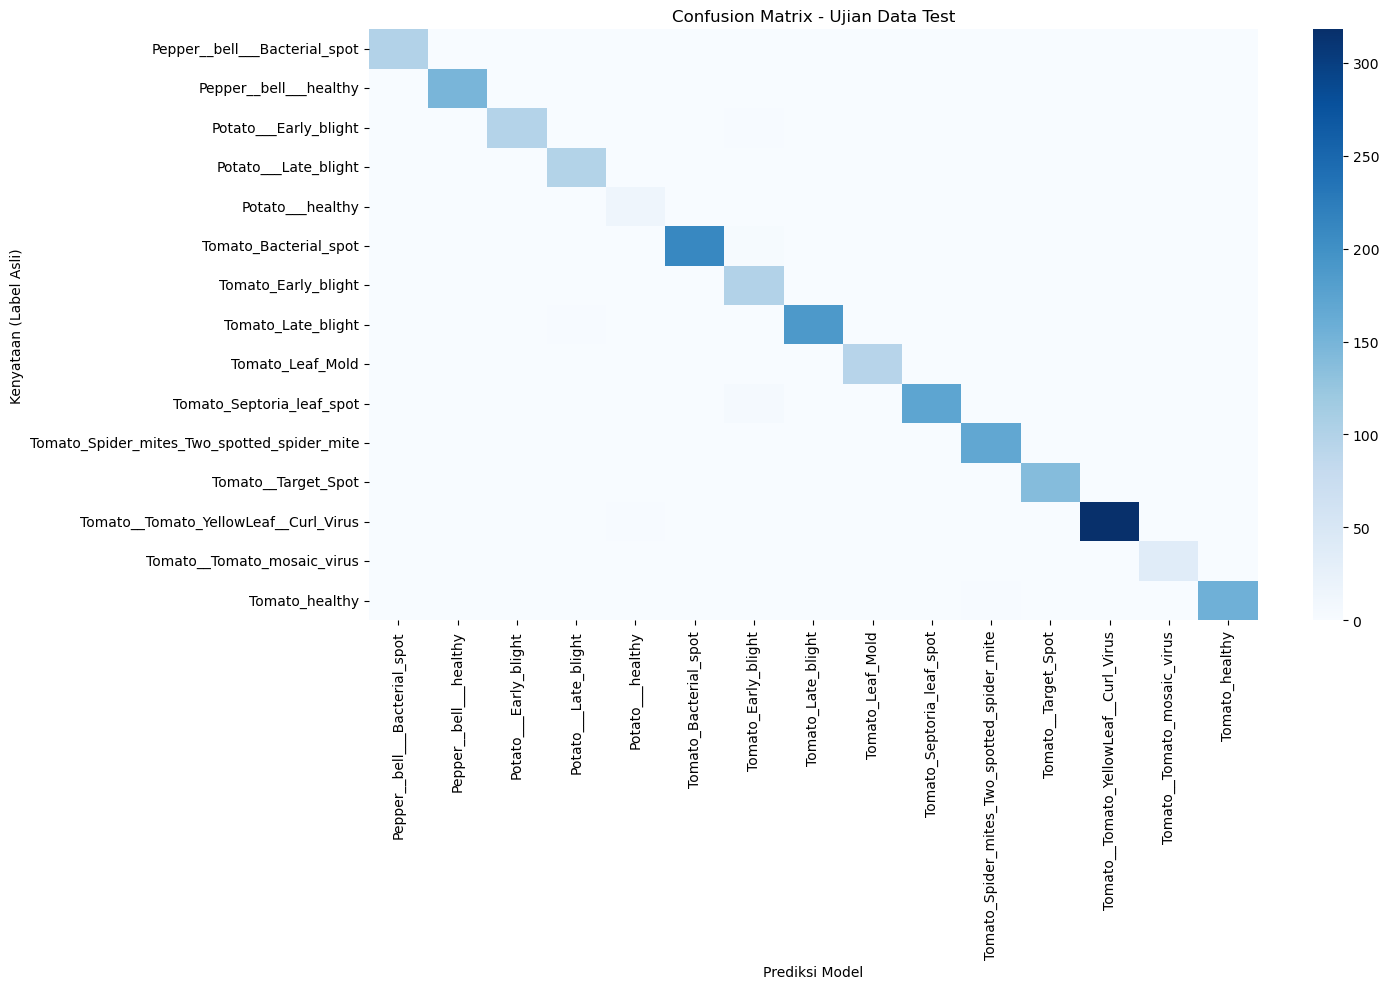

In [9]:
print("\n Ujian Akhir Model pada Data TEST...")
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# F1 Score Report
print("\n HASIL F1 SCORE (Data Test):")
# Tambahkan zero_division=0 agar tidak muncul warning jika ada kelas yang tidak terprediksi
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Ujian Data Test')
plt.xlabel('Prediksi Model')
plt.ylabel('Kenyataan (Label Asli)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
print("\n Selesai! Gambar Confusion Matrix disimpan sebagai 'confusion_matrix.png'")